In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
from scipy import ndimage
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [2]:
tf.version.VERSION

'2.8.0'

In [3]:
def make_dataset_balls(csv_file, imgs_dir):
  imgs_records = pd.read_csv(csv_file)
  imgs_arr = []
  bboxes = []
  labels = []
  for index, row in tqdm(imgs_records.iterrows()):
      (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
      imgs_path = os.path.join(os.getcwd(), imgs_dir)
      img_fullpath = os.path.join(imgs_path, filename)
      shape = (320, 240)
      img = keras.preprocessing.image.load_img(img_fullpath)
      if img.size[0] > img.size[1]:
          width = img.size[0]
          height = img.size[1]
          img = ndimage.rotate(img, 90, mode = 'mirror')
          xmin1 = ymin
          xmax1 = ymax
          ymin1 = width - xmax
          ymax1 = width - xmin
          xmin, ymin, xmax, ymax = xmin1, ymin1, xmax1, ymax1
      else:
          width = img.size[1]
          height = img.size[0]
      img = tf.image.resize(img, shape, method="nearest")
      img = tf.cast(img, tf.float32) / 255.0
      img_arr = keras.preprocessing.image.img_to_array(img)
      imgs_arr.append(img_arr)
      xmin = round(xmin/ (width/320), 2)
      ymin = round(ymin/ (height/240), 2)
      xmax = round(xmax/ (width/320), 2)
      ymax = round(ymax/ (height/240), 2)
      bboxes.append((xmin, ymin, xmax, ymax))
      labels.append(1)
  return imgs_arr, bboxes, labels

In [15]:
def make_dataset_no_balls(imgs_dir, imgs_arr, bboxes, labels):
    p = Path(imgs_dir)
    shape = (320, 240)
    for img_path in tqdm(p.glob('*.jpg')):
        img = keras.preprocessing.image.load_img(img_path)
        if img.size[0] > img.size[1]:
            img = ndimage.rotate(img, 90, mode = 'mirror')
        img = tf.image.resize(img, shape, method="nearest")
        img = tf.cast(img, tf.float32) / 255.0
        img_arr = keras.preprocessing.image.img_to_array(img)
        imgs_arr.append(img_arr)
        bboxes.append((0, 0, 0, 0))
        labels.append(0)
    return imgs_arr, bboxes, labels

In [5]:
def show_dataset_item(imgs, bboxes, classes, labels):
  print(f"bboxes: {bboxes[-1]}")
  print(f"class: {classes[labels[-1]]}")
  plt.imshow(imgs[-1])
  plt.colorbar()
  plt.show()

In [6]:
classes = ['no-ball', 'ball']

334it [05:55,  1.06s/it]


Train dataset with balls:
bboxes: (121.11, 233.41, 140.63, 256.35)
class: ball


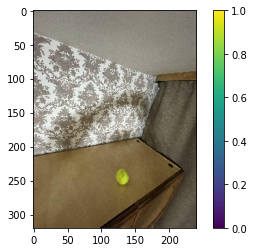

In [7]:
balls_csv = 'balls/_annotations.csv'
dir_balls = 'balls'
dir_no_balls = 'no_balls'

train_imgs, train_bboxes, train_labels = make_dataset_balls(balls_csv, dir_balls)
print("Train dataset with balls:")
show_dataset_item(train_imgs, train_bboxes, classes, train_labels)

290it [05:01,  1.04s/it]


Train dataset with no balls:
bboxes: (0, 0, 0, 0)
class: no-ball


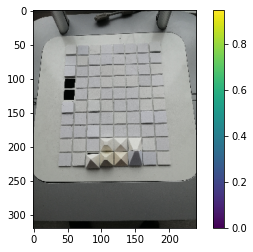

In [16]:
train_imgs, train_bboxes, train_labels = make_dataset_no_balls(dir_no_balls, train_imgs, train_bboxes, train_labels)
print("Train dataset with no balls:")
show_dataset_item(train_imgs, train_bboxes, classes, train_labels)

51it [00:08,  6.32it/s]


Validation dataset with balls:
bboxes: (50.24, 159.84, 71.11, 180.08)
class: ball


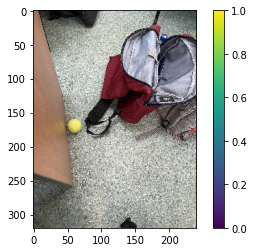

In [17]:
valid_balls_csv = 'validate_balls/_annotations.csv'
valid_dir_balls = 'validate_balls'
valid_dir_no_balls = 'validate_no_balls'

valid_imgs, valid_bboxes, valid_labels = make_dataset_balls(valid_balls_csv, valid_dir_balls)
print("Validation dataset with balls:")
show_dataset_item(valid_imgs, valid_bboxes, classes, valid_labels)

23it [00:03,  6.44it/s]


Validation dataset with no balls:
bboxes: (0, 0, 0, 0)
class: no-ball


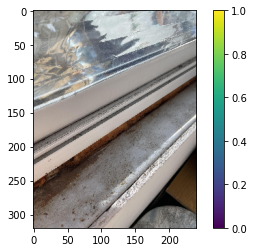

In [18]:
valid_imgs, valid_bboxes, valid_labels = make_dataset_no_balls(valid_dir_no_balls, valid_imgs, valid_bboxes, valid_labels)
print("Validation dataset with no balls:")
show_dataset_item(valid_imgs, valid_bboxes, classes, valid_labels)

In [19]:
train_imgs = np.array(train_imgs)
train_bboxes = np.array(train_bboxes)
train_labels = np.array(train_labels)

valid_imgs = np.array(valid_imgs)
valid_bboxes = np.array(valid_bboxes)
valid_labels = np.array(valid_labels)

In [21]:
input_shape = (320, 240, 3)
input_layer = tf.keras.layers.Input(input_shape)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_1')(input_layer)
base_layers = layers.MaxPooling2D(name='bl_2')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_3')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_4')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_5')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_6')(base_layers)
base_layers = layers.Flatten(name='bl_7')(base_layers)

In [22]:
num_classes = 2
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  

In [23]:
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [24]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

In [25]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
          "bb_head":tf.keras.losses.MSE}

In [26]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Conv2D)                  (None, 320, 240, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bl_2 (MaxPooling2D)            (None, 160, 120, 16  0           ['bl_1[0][0]']                   
                                )                                                             

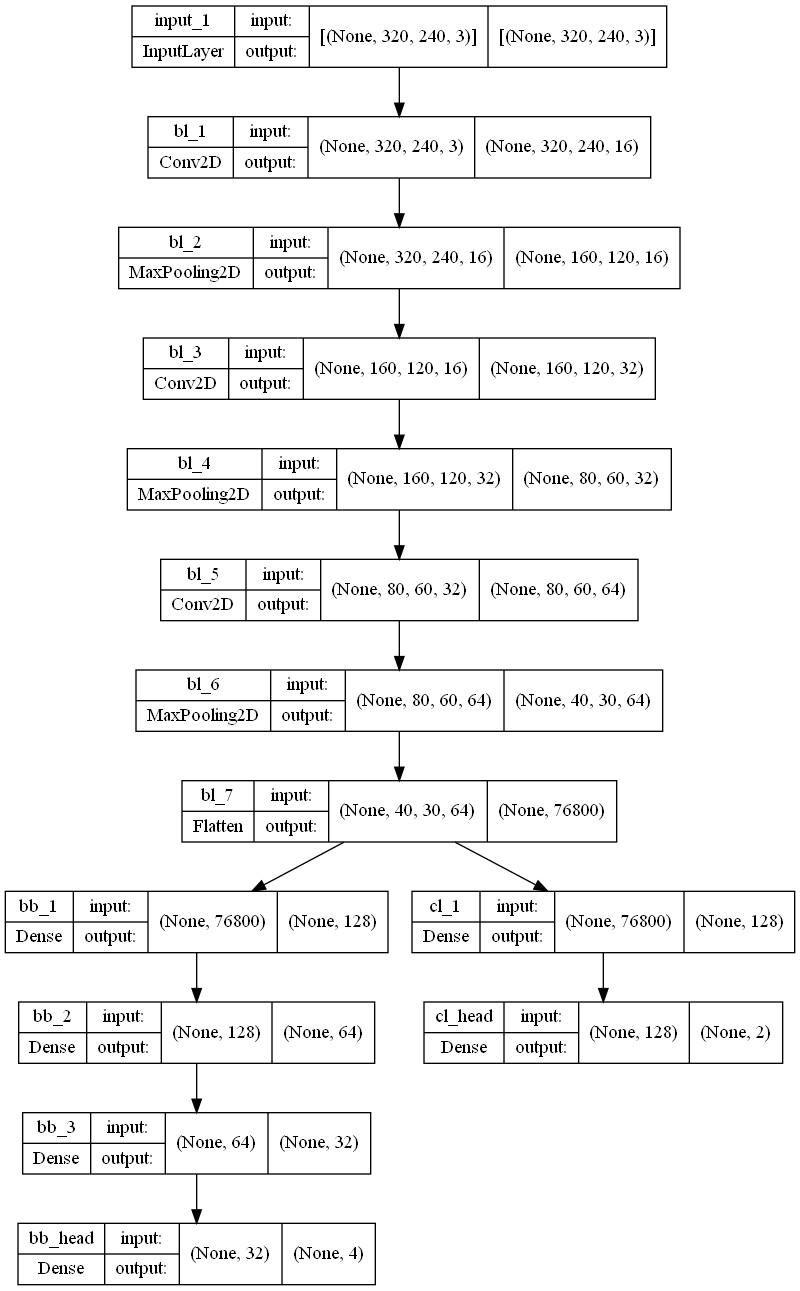

In [28]:
plot_model(model, show_shapes=True)

In [29]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_bboxes
}
validationTargets = {
    "cl_head": valid_labels,
    "bb_head": valid_bboxes
}

In [30]:
os.makedirs("saved/models/", exist_ok=True)

In [31]:
history = model.fit(train_imgs, trainTargets,
             validation_data=(valid_imgs, validationTargets),
             batch_size=16,
             epochs=100,
             shuffle=True,
             verbose=1)

Epoch 1/100
40/40 [==============================] - 40s 829ms/step - loss: 11769.6729 - cl_head_loss: 1.2477 - bb_head_loss: 11768.4248 - cl_head_accuracy: 0.5304 - bb_head_accuracy: 0.4824 - val_loss: 17002.9648 - val_cl_head_loss: 0.8014 - val_bb_head_loss: 17002.1621 - val_cl_head_accuracy: 0.3108 - val_bb_head_accuracy: 0.5405
Epoch 2/100
40/40 [==============================] - 30s 761ms/step - loss: 11766.4805 - cl_head_loss: 0.6238 - bb_head_loss: 11765.8564 - cl_head_accuracy: 0.6278 - bb_head_accuracy: 0.4489 - val_loss: 17003.0156 - val_cl_head_loss: 0.8633 - val_bb_head_loss: 17002.1523 - val_cl_head_accuracy: 0.3514 - val_bb_head_accuracy: 0.3243
Epoch 3/100
40/40 [==============================] - 34s 848ms/step - loss: 11766.4189 - cl_head_loss: 0.5619 - bb_head_loss: 11765.8525 - cl_head_accuracy: 0.7316 - bb_head_accuracy: 0.4728 - val_loss: 17002.7070 - val_cl_head_loss: 0.5564 - val_bb_head_loss: 17002.1523 - val_cl_head_accuracy: 0.7297 - val_bb_head_accuracy: 0.310

In [33]:
model.save_weights('saved/models/model_epoch100')

In [34]:
model.save('saved/models/model1.h5')

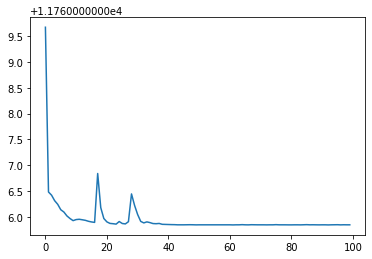

In [35]:
plt.plot(history.epoch, history.history["loss"])

In [41]:
history.history.keys()

dict_keys(['loss', 'cl_head_loss', 'bb_head_loss', 'cl_head_accuracy', 'bb_head_accuracy', 'val_loss', 'val_cl_head_loss', 'val_bb_head_loss', 'val_cl_head_accuracy', 'val_bb_head_accuracy'])

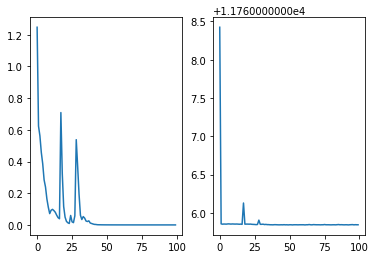

In [42]:
plt.subplot(121)
plt.plot(history.epoch, history.history["cl_head_loss"])
plt.subplot(122)
plt.plot(history.epoch, history.history["bb_head_loss"])
plt.show()

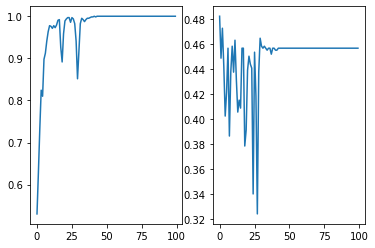

In [43]:
plt.subplot(121)
plt.plot(history.epoch, history.history["cl_head_accuracy"])
plt.subplot(122)
plt.plot(history.epoch, history.history["bb_head_accuracy"])
plt.show()

In [ ]:
p = Path(imgs_dir)
shape = (320, 240)
for img_path in tqdm(p.glob('*.jpg')):
    img = keras.preprocessing.image.load_img(img_path)
    if img.size[0] > img.size[1]:
        img = ndimage.rotate(img, 90, mode = 'mirror')
    img = tf.image.resize(img, shape, method="nearest")
    img = tf.cast(img, tf.float32) / 255.0
    img_arr = keras.preprocessing.image.img_to_array(img)
    imgs_arr.append(img_arr)
    bboxes.append((0, 0, 0, 0))
    labels.append(0)

In [44]:
test_imgs = []
p = Path('test')
shape = (320, 240)
for img_path in tqdm(p.glob('*.jpg')):
    img = keras.preprocessing.image.load_img(img_path)
    if img.size[0] > img.size[1]:
        img = ndimage.rotate(img, 90, mode = 'mirror')
    img = tf.image.resize(img, shape, method="nearest")
    img = tf.cast(img, tf.float32) / 255.0
    img_arr = keras.preprocessing.image.img_to_array(img)
    test_imgs.append(img_arr)

24it [00:04,  5.14it/s]


In [92]:
def show_test(ind, imgs_dir, model, classes):
    image = imgs_dir[ind]
    prediction = model.predict(image[tf.newaxis, ...])
    print(f"bbox: {prediction[1]}")
    print(f"class: {classes[np.argmax(prediction[0])]} from no-ball: {prediction[0][0][0]}, ball: {prediction[0][0][1]}")
    plt.title(classes[np.argmax(prediction[0])])
    plt.imshow(image)
    plt.show()

Видно, что шарика нет, но понятно, что координаты сбиты...

bbox: [[1. 1. 1. 1.]]
class: no-ball from no-ball: 5.657080173492432, ball: -9.412811279296875


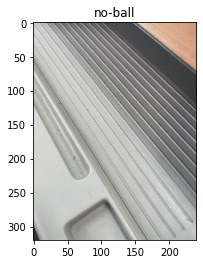

In [93]:
ind = 18
show_test(ind, test_imgs, model, classes)

Шарик точно есть

bbox: [[1. 1. 1. 1.]]
class: ball from no-ball: -9.318042755126953, ball: 1.4253426790237427


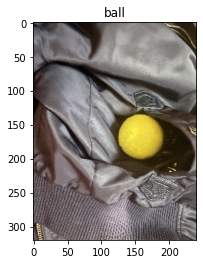

In [94]:
ind = 7
show_test(ind, test_imgs, model, classes)

По вероятностям видно неуверенность

bbox: [[1. 1. 1. 1.]]
class: no-ball from no-ball: -1.8337701559066772, ball: -4.446235179901123


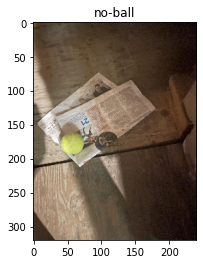

In [95]:
ind = 0
show_test(ind, test_imgs, model, classes)